# Creating a Kaggle Workflow

This project uses the [Titanic Dataset](https://www.kaggle.com/c/titanic), and aims to build on work previously conducted in isolation to build a workflow that will combine:

- **Data exploration**, to find patterns in the data
- **Feature engineering**, to create new features from these patterns or through experimentation
- **Feature selection**, to select the best subset of the current set of features, and
- **Model selection/tuning**, training multiple models with different hyperparameters to find the best performer

In [1]:
import pandas as pd
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing the Data

Importing functions created earlier, specifically to:
- fillna's
- create labels and categorise continuous variables
- create dummy columns and assign back into the dataframe
- create bins
- extract string data into a new column

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def pre_processing(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for col in ['Age_categories', 'Fare_categories', 
                'Title', 'Cabin_type', 'Sex']:
        df = create_dummies(df,col)
    return df

In [5]:
train = pre_processing(train)
holdout = pre_processing(holdout)

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


## Exploring the Data

I will look specifically at the following columns:
- `SibSp`, the number of siblings or spouses the passenger had on board
- `Parch`, the number of parents or children the passenger had on board
- `family_size`, a column I will create combining the above two columns so we can view overall family size

All of these will be reviewed against the `Survived` column, to look for patterns between family size on board and survival rates.

In [7]:
to_explore = train[['SibSp', 'Parch', 'Survived']].copy()
print(to_explore.info(),'\n', to_explore.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB
None 
             SibSp       Parch    Survived
count  891.000000  891.000000  891.000000
mean     0.523008    0.381594    0.383838
std      1.102743    0.806057    0.486592
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000
75%      1.000000    0.000000    1.000000
max      8.000000    6.000000    1.000000


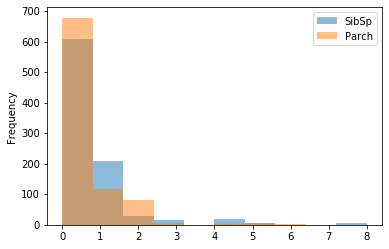

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

to_explore.drop('Survived', axis=1).plot.hist(alpha=0.5)

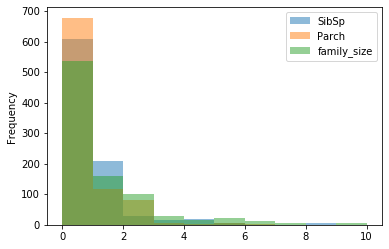

In [9]:
to_explore['family_size'] = to_explore[['SibSp', 'Parch']].sum(axis=1)
to_explore.drop('Survived', axis=1).plot.hist(alpha=0.5)

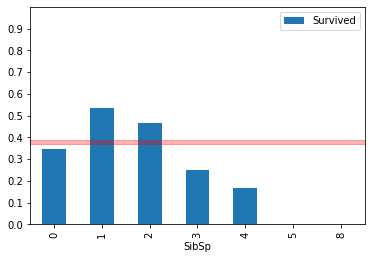

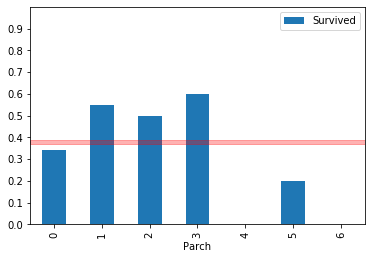

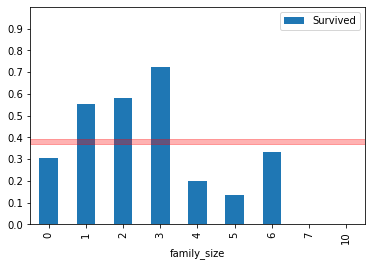

In [10]:
import numpy as np
for col in to_explore.columns.drop('Survived'):
    pivot = to_explore.pivot_table(index=col, values='Survived')
    pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,.1))
    plt.axhspan(.37,.39, alpha=0.3, color='red')
    plt.show()

From exploring the columns above, we can see that passengers with a family size of 1 (either a sibling, spouse, parent or child), 2 or 3 had higher survival rates than large families or solo passengers.

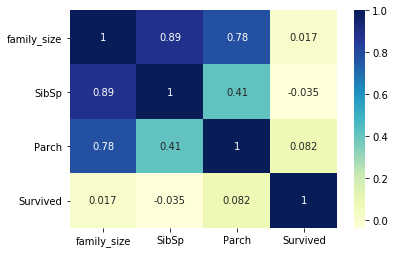

In [11]:
import seaborn as sns
sns.heatmap(to_explore[['family_size', 'SibSp', 'Parch', 'Survived']].corr(), annot=True, cmap='YlGnBu')
plt.show()

## Engineering New Features

In [12]:
def solo_passenger(df):
    df['family_size'] = df[['SibSp', 'Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['family_size'] == 0), 'isalone'] = 1 
    return df

In [13]:
solo_passenger(train)
solo_passenger(holdout)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male,family_size,isalone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,1,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,1,1,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,1,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,0,0,0,0,0,1,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,0,0,0,0,0,1,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,-0.5,0,0,A.5. 3236,8.0500,S,...,0,0,0,0,0,1,0,1,0,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,...,1,0,0,0,0,0,1,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,...,0,0,0,0,0,1,0,1,0,1
416,1308,3,"Ware, Mr. Frederick",male,-0.5,0,0,359309,8.0500,S,...,0,0,0,0,0,1,0,1,0,1


## Feature Selection

Here I can use scikit-learn's [feature_selection.RFECV class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) to automate the selection of best perforning features through recursive feature elimination using cross-validation.

To speed things up a bit I will create a function to perform this process, meaning I can perform feature selection by calling a self-contained function. Through previous feature selection and model tuning I will choose Random Forests as the appropriate algorithm to be input as the estimator within the function.

In [14]:
train.dtypes

PassengerId                      int64
Survived                         int64
Pclass                           int64
Name                            object
Sex                             object
Age                            float64
SibSp                            int64
Parch                            int64
Ticket                          object
Fare                           float64
Embarked                        object
Age_categories                category
Fare_categories               category
Title                           object
Cabin_type                      object
Age_categories_Missing           uint8
Age_categories_Infant            uint8
Age_categories_Child             uint8
Age_categories_Teenager          uint8
Age_categories_Young Adult       uint8
Age_categories_Adult             uint8
Age_categories_Senior            uint8
Fare_categories_0-12             uint8
Fare_categories_12-50            uint8
Fare_categories_50-100           uint8
Fare_categories_100+     

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['Survived', 'PassengerId'], axis=1)
    all_y = df['Survived']
    
    clf = RandomForestClassifier(random_state=1) 
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)  
    best_cols = list(all_X.columns[selector.support_])
    return best_cols

In [16]:
cols = select_features(train)

## Model Selection/Tuning

Now we have a list of best columns to train the model with, it's time to create a function which will iterate through a dictionary containing different models and hyperparameters to find the optimised model.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    models = [
        {'name': 'LogisticRegression',
        'estimator': LogisticRegression(),
        'hyperparameters': 
        {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
         'max_iter':[400]
        }},
        {'name': 'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'hyperparameters':
        {'n_neighbors': range(1,20,2),
        'weights': ['distance', 'uniform'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'p': [1,2]
        }},
        {'name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier(),
        'hyperparameters': 
        {'n_estimators': [4,6,9],
        'criterion': ['entropy', 'gini'],
        'max_depth': [2,5,10],
        'max_features': ['log2', 'sqrt'],
        'min_samples_leaf': [1,5,8],
        'min_samples_split': [2,3,5]
        }}
    ]
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [24]:
best_model = select_model(train, cols)

LogisticRegression
------------------


C:\Users\George Boorman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\George Boorman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

Best Score: 0.8227215980024969
Best Parameters: {'max_iter': 300, 'solver': 'lbfgs'}

KNeighborsClassifier
--------------------
Best Score: 0.7822971285892635
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8383770287141074
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 6}



# Making a Submission to Kaggle

In [25]:
def save_submission_file(model, cols, file_name='submission.csv'):
    holdout_predictions = model.predict(holdout[cols])
    submission_df = pd.DataFrame({'PassengerId': holdout['PassengerId'],
                                 'Survived': holdout_predictions})
    submission_df.to_csv(file_name, index=False)

best_rf_model = best_model[2]['best_model']
save_submission_file(best_rf_model, cols)